# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf

C:\Users\Kirill\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

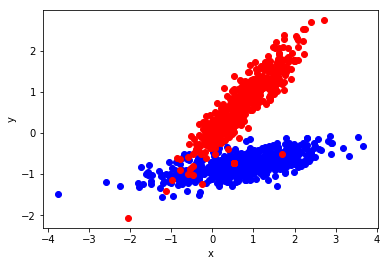

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [5]:
import random
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(random.choices(string.ascii_letters, k = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [25]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1. / (1 + np.exp(-X))

def sigmoid_op_backward(op, grads):
    sigmoid = op.outputs[0]
    return sigmoid * (1 - sigmoid) * grads

## Создание графа вычислений и обучение модели

In [29]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.9).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(20):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.770 weights=[[0.4106604  0.18571192]]
[010] loss=0.677 weights=[[ 0.1547773  -0.60027647]]
[020] loss=0.663 weights=[[ 0.04350976 -1.1902974 ]]
[030] loss=0.614 weights=[[ 0.01765607 -1.6152526 ]]
[040] loss=0.615 weights=[[ 0.04177309 -1.9406481 ]]
[050] loss=0.587 weights=[[ 0.0661652 -2.2098556]]
[060] loss=0.623 weights=[[ 0.08854967 -2.4385414 ]]
[070] loss=0.594 weights=[[ 0.11899327 -2.6324892 ]]
[080] loss=0.563 weights=[[ 0.14065537 -2.8074687 ]]
[090] loss=0.572 weights=[[ 0.15707546 -2.9642825 ]]
[100] loss=0.593 weights=[[ 0.18080674 -3.1012082 ]]
[110] loss=0.540 weights=[[ 0.19805965 -3.2340565 ]]
[120] loss=0.558 weights=[[ 0.20213722 -3.351752  ]]
[130] loss=0.585 weights=[[ 0.21489488 -3.4641309 ]]
[140] loss=0.545 weights=[[ 0.22622916 -3.56669   ]]
[150] loss=0.576 weights=[[ 0.24142504 -3.6598792 ]]
[160] loss=0.556 weights=[[ 0.24939223 -3.751566  ]]
[170] loss=0.569 weights=[[ 0.25675943 -3.8388367 ]]
[180] loss=0.610 weights=[[ 0.2583179 -3.9198034]]

## Визуализируем кривую обучения

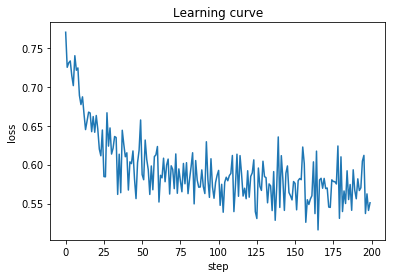

In [30]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

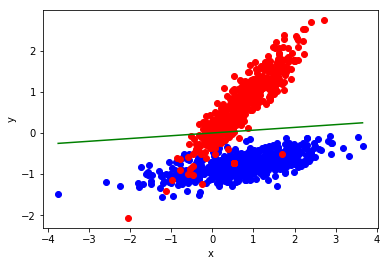

In [31]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');

---

---

---

In [112]:
# Importing
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn.datasets
from sklearn.metrics import accuracy_score
from random import uniform
from math import exp, log
from collections import OrderedDict
from pprint import pprint

# Plot settings
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [151]:
def generate_moons(n_samples=200, noise=0.2, visualize=True):
    X, y = sklearn.datasets.make_moons(n_samples, noise=noise)
    if visualize:
        plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
    return X, y

def get_random_number(a=-1, b=1):
    return uniform(a, b)

def ReLU(x, return_derivative=False):
    if not return_derivative:
        return max(0, x)
    else:
        return (x > 0) * 1

def softplus(x, return_derivative=False, limit=30):
    if not return_derivative:
        if x > limit:
            return x
        else:
            return log(1 + exp(x))
    else:
        return sigmoid(x)

def sigmoid(x, return_derivative=False):
    if not return_derivative:
        try:
            res = 1 / (1 + exp(-x))
        except OverflowError:
            res = 0
    else:
        res = sigmoid(x) * (1 - sigmoid(x))
    return res

def log_loss(y, p, return_derivative=False):
    if not return_derivative:
        try:
            logarithm_p = log(p)
        except ValueError:
            logarithm_p = -744
        try:
            logarithm_1_p = log(1-p)
        except ValueError:
            logarithm_1_p = -744
        return -(y*logarithm_p + (1-y)*logarithm_1_p)
    else:
        return -((y - p) / (p * (1 - p))) * (p * (1 - p))

In [152]:
class WeightedConnection:
    def __init__(self, weight=None, input_neuron=None, output_neuron=None):
        if weight is None:
            weight = get_random_number(0, 1)
        self.weight = weight
        self.input_neuron = input_neuron
        self.output_neuron = output_neuron

        self.updated_weight = None
        self.anti_gradient = None
        
    def send_signal_through_connection(self, signal):
        if not self.input_neuron or not self.output_neuron:
            print('Cannot send signal, because '
                  'there is no input/output connection')
            return False
        self.output_neuron.receive_new_input_signal_from(self, signal*self.weight)

In [153]:
class Neuron:
    instance_counter = 0

    def __init__(self, activation_function=ReLU):
        Neuron.instance_counter += 1
        self.name = str(Neuron.instance_counter) 
        self.activation_function = activation_function
        self.last_value = None
        self.bias = 0
        self.updated_bias = None
        # input_connection = {WeightedConnection(): input_value}
        self.input_connections = OrderedDict()
        self.received_signals_from = set()

        # output_connection = set(WeightedConnection())
        self.output_connections = set()

    def create_output_connection_with(self, neuron, weight=None, input_value=None):
        new_neuron_connection = WeightedConnection(weight=weight,
                                                   input_neuron=self,
                                                   output_neuron=neuron)
        self.output_connections.add(new_neuron_connection)
        neuron.input_connections[new_neuron_connection] = input_value
        return True

    def receive_new_input_signal_from(self, connection, weighted_signal):
        if connection not in self.input_connections:
            print('Cannot receive new input signal, because no such input neuron')
            return False
        self.input_connections[connection] = weighted_signal
        self.received_signals_from.add(connection)
        return True

    def has_received_signals_from_all_connections(self):
        if self.is_input_neuron():
            if self.last_value is None:
                return False
        elif self.is_middle_neuron() or self.is_output_neuron():
            if (not self.input_connections) or \
                (not self.received_signals_from) or \
                 (len(self.input_connections) != len(self.received_signals_from)):
                return False
        else:
            print('Cannot determine neuron type')
            return False
        return True
    
    def activate(self):
        if self.is_input_neuron():
            if len(self.output_connections) == 0:
                print("Cannot activate input neuron, "
                      "because it has no output connecitons")
                return False
        elif self.is_output_neuron():
            if (len(self.input_connections) == 0) or \
                    (not self.has_received_signals_from_all_connections()):
                print("Cannot activate output neuron, "
                      "because it has no input connecitons")
                return False
        elif self.is_middle_neuron():
            if (None in self.input_connections.values()) or \
                   (not self.has_received_signals_from_all_connections()):
                print("Cannot activate neuron, "
                      "because it hasn't received all signals "
                      "from each input neuron yet")
                return False
        else:
            print('Cannot determine neuron type')
            return False
        # calculate activated input signal
        input_signal = 0
        if self.is_input_neuron():
            if self.last_value is None:
                print("Cannot activate input neuron, "
                      "because its last value is empty")
                return False
            input_signal = self.last_value
        else:
            for input_connection, input_value in self.input_connections.items():
                input_signal += input_value
        self.last_value = self.activation_function(input_signal + self.bias)

        # send signal through each output conneciton
        for output_connection in self.output_connections:
            output_connection.send_signal_through_connection(self.last_value)

        # ready to receive new signals
        self.received_signals_from = set()
        return True

    def calculate_anti_gradient(self):
        if self.is_input_neuron():
            if len(self.output_connections) == 0:
                print("Cannot calculate anti-gradient, "
                      "because neuron has no output connecitons")
                return None
        elif self.is_output_neuron():
            print("For calculation of output neuron anti-gradient "
                  "use cost function derivative")
            return None
        elif self.is_middle_neuron():
            if None in self.input_connections.values():
                print("Cannot calculate anti-gradient, "
                      "because neuron hasn't received all signals "
                      "from each input neuron yet")
                return None
        else:
            print('Cannot determine neuron type')
            return None
        # calculate activated output signal
        anti_gradient = 0
        for output_connection in self.output_connections:
            if output_connection.anti_gradient is None:
                print("Cannot calculate neuron anti-gradient, "
                      "because there is 'None' in "
                      "one of neurons output connections")
                return None
            anti_gradient += output_connection.anti_gradient
        return anti_gradient

    def is_input_neuron(self):
        if len(self.input_connections) == 0 and len(self.output_connections) > 0:
            return True
        else:
            return False

    def is_middle_neuron(self):
        if len(self.input_connections) > 0 and len(self.output_connections) > 0:
            return True
        else:
            return False
        
    def is_output_neuron(self):
        if len(self.input_connections) > 0 and len(self.output_connections) == 0:
            return True
        else:
            return False

In [154]:
class FullyConnectedNeuroNetwork:
    def __init__(self, cost_function=log_loss, learning_rate=0.01):
        self.layers = []
        self.cost_function = cost_function
        self.learning_rate = learning_rate
        self.ready_to_back_propagate = False
        Neuron.instance_counter = 0
    
    def add_layer(self, number_of_neurons, activation_function=ReLU):
        if len(self.layers) == 0:
            if not self.add_input_layer(number_of_neurons, activation_function):
                return False
        else:
            if not self.add_fully_connected_layer(number_of_neurons, activation_function):
                return False
        return True
        
    def add_input_layer(self, number_of_neurons, activation_function=ReLU):
        if len(self.layers) > 0:
            print('Cannot add input layer, because it is already exists')
            return False
        else:
            new_neuron_layer = tuple(
                Neuron(activation_function=activation_function) \
                    for neuron in range(number_of_neurons)
            )
            self.layers.append(new_neuron_layer)
            return True
        
    def add_fully_connected_layer(self, number_of_neurons, activation_function=ReLU):
        if len(self.layers) > 0:
            new_neuron_layer = tuple(
                Neuron(activation_function=activation_function) \
                    for neuron in range(number_of_neurons)
            )
            previous_layer = self.layers[-1]
            for output_neuron in previous_layer:
                for input_neuron in new_neuron_layer:
                    output_neuron.create_output_connection_with(input_neuron)
            self.layers.append(new_neuron_layer)
            return True
        else:
            print('Cannot add fully_connected layer, because neural network is empty')
            return False
        
    def get_input_layer(self):
        if len(self.layers) > 0:
            return self.layers[0]
        else:
            print('Cannot get input layer, because neural network is empty')
            return None
        
    def get_output_layer(self):
        if len(self.layers) > 0:
            return self.layers[-1]
        else:
            print('Cannot get output layer, because neural network is empty')
            return None

    def is_input_layer(self, layer_index):
        return layer_index == 0

    def is_middle_layer(self, layer_index):
        return layer_index > 0 and layer_index < len(self.layers)

    def is_output_layer(self, layer_index):
        return layer_index == len(self.layers)
        
    def forward_calculate(self, input_values, true_y):
        if len(self.layers) < 1:
            print('Cannot forward calculate, because neural network is empty')
            return False
        elif len(input_values) < len(self.layers[0]):
            print('Cannot forward calculate, not enough input values were given')
            return False
        else:
            for input_neuron, input_value in zip(self.layers[0], input_values):
                input_neuron.last_value = input_value
            for layer in self.layers:
                for neuron in layer:
                    neuron.activate()
            output_neurons_values = [neuron.last_value for neuron in self.layers[-1]]
            predicted_y = \
                sum(output_neurons_values) / len(output_neurons_values)
            self.ready_to_back_propagate = True
            loss = self.cost_function(true_y, predicted_y)
            return true_y, predicted_y, loss
    
    def backward_propagate(self, true_y, predicted_y):
        if len(self.layers) < 1:
            print('Cannot backward propagate, because neural network is empty')
            return False
        elif not self.ready_to_back_propagate:
            print('Cannot backward propagate, because did not forward calculated yet')
            return False
        else:
            for layer in reversed(self.layers):
                anti_gradient = None
                if layer == self.layers[-1]:
                    anti_gradient = self.cost_function(true_y,
                                                       predicted_y,
                                                       return_derivative=True)
                if not self.backward_propagate_layer(layer, anti_gradient=anti_gradient):
                    print('Cannot backward propagate through layer:', self.layers.index(layer))
                    return False
            self.ready_to_back_propagate = False
            if not self.update_weights_and_biases():
                print('Cannot update weights')
                return False
            self.reset_anti_gradients_updated_weights_and_last_values()
            return True
    
    def backward_propagate_layer(self, layer, anti_gradient=None):
        for neuron in layer:
            if not self.backward_propagate_neuron(neuron, anti_gradient=anti_gradient):
                print('Cannot backward propagate through neuron:', neuron.name)
                return False
        return True
    
    def backward_propagate_neuron(self, neuron, anti_gradient=None):
        if anti_gradient is None:
            anti_gradient = neuron.calculate_anti_gradient()
        # update weights
        for input_connection in neuron.input_connections:
            if not self.backward_propagate_input_connection(input_connection,
                                                            anti_gradient):
                print('Cannot back propagate connection:', input_connection)
                return False
        # bias update
        new_anti_gradient = \
            anti_gradient * \
                neuron.activation_function(neuron.bias, return_derivative=True)
        neuron.updated_bias = \
            neuron.bias - self.learning_rate * new_anti_gradient
        return True
    
    def backward_propagate_input_connection(self, connection, anti_gradient):
        if anti_gradient is None:
            print("Cannot back propagate, because connection anti-gradient is 'None'")
            return False
        weighted_signal = connection.output_neuron.input_connections.get(connection)
        if weighted_signal is None:
            print("Cannot back propagate, because no signal was send "
                  "through connection:", connection)
            return False
        new_anti_gradient = \
            anti_gradient * \
                connection.output_neuron.activation_function(
                    weighted_signal,
                    return_derivative=True
                )
        connection.updated_weight = \
            connection.weight - self.learning_rate*new_anti_gradient
        connection.anti_gradient = new_anti_gradient
        return True
    
    def update_weights_and_biases(self):
        for layer in self.layers:
            for neuron in layer:
                for output_connection in neuron.output_connections:
                    if output_connection.updated_weight is None:
                        print("Updated weight is 'None'")
                        return False
                    output_connection.weight = output_connection.updated_weight
                if neuron.updated_bias is None:
                    print("Neuron updated bias is 'None'")
                else:
                    neuron.bias = neuron.updated_bias
        return True
    
    def reset_anti_gradients_updated_weights_and_last_values(self):
        for layer in self.layers:
            for neuron in layer:
                neuron.last_value = None
                neuron.updated_bias = None
                for output_connection in neuron.output_connections:
                    output_connection.updated_weight = None
                    output_connection.anti_gradient = None
        return True

In [159]:
# [x, y, true_class]
def generate_data(count=1000):
    data = []
    for i in range(1, count):
        x = get_random_number(0, 1)
        y = get_random_number(0, 1)
        true_class = 1 if y > x else 0
        data.append((x, y, true_class))
    return data

In [170]:
neural_network = FullyConnectedNeuroNetwork()
neural_network.add_layer(2, activation_function=sigmoid)
neural_network.add_layer(4, activation_function=sigmoid)
neural_network.add_layer(2, activation_function=sigmoid)

True

In [171]:
for i in range(0, 20):
    sum_loss = 0
    counter = 0
    data = generate_data()
    for j in range(len(data)):
        input_values = data[j][:-1]
        true_class = data[j][-1]
        counter += 1
        true_class, predicted_class, loss = \
            neural_network.forward_calculate(input_values, true_class)
        sum_loss += loss
        neural_network.backward_propagate(true_class, predicted_class)
    print('Loss: {:.5f}'.format(sum_loss / counter), end=' -->  ')

Loss: 0.71552 -->  Loss: 0.69461 -->  Loss: 0.69457 -->  Loss: 0.69461 -->  Loss: 0.69406 -->  Loss: 0.69373 -->  Loss: 0.69453 -->  Loss: 0.69499 -->  Loss: 0.69423 -->  Loss: 0.69210 -->  Loss: 0.69543 -->  Loss: 0.69466 -->  Loss: 0.69370 -->  Loss: 0.69466 -->  Loss: 0.69466 -->  Loss: 0.69475 -->  Loss: 0.69350 -->  Loss: 0.69275 -->  Loss: 0.69301 -->  Loss: 0.69501 -->  

In [174]:
true_y = []
predicted_y = []

data = generate_data(10000)
for each in data:
    true_class, predicted_class, loss = \
        neural_network.forward_calculate(each[:-1], each[-1])
    neural_network.reset_anti_gradients_updated_weights_and_last_values()
    true_y.append(each[-1])
    predicted_class = \
        1 if predicted_class >= 0.5 else 0
    predicted_y.append(predicted_class)

In [164]:
y_true = np.array(true_y)
y_pred = np.array(predicted_y)

In [165]:
accuracy_score(y_true, y_pred)

0.49624962496249625